# Models and policy

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
  - 1.1. [Tests](#toc1_1_)    
- 2. [Transition path](#toc2_)    
- 3. [Simulation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a Heterogenous Agent New Keynessian (HANK) model with a search-and-match labor markt** using the ``GEModelTools`` package.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.optimize as optimize

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKSAMModel import HANKSAMModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKSAMModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss
path = model.path

In [4]:
model.info()

settings:
 par.py_hh = True
 par.py_block = True
 par.full_z_trans = True
 par.T = 300

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [w,RealR_ex_post,tau]
 inputs_hh_z: [delta,lambda_u]
 outputs_hh: [a,c,s]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [shock_TFP,delta,w]
 unknowns: [px,Vj,vt,ut,S,Pi]
 targets: [errors_Vj,errors_ut,errors_entry,errors_Pi,errors_assets,errors_search]

blocks (inputs -> outputs):
 production: [shock_TFP,delta,w,px,Vj] -> [errors_Vj]
 labor_market: [vt,ut,S,delta] -> [theta,lambda_v,lambda_u,v,u,entry,errors_ut]
 entry: [lambda_v,Vj] -> [errors_entry]
 price_setters: [shock_TFP,u,px,Pi] -> [errors_Pi]
 central_bank: [Pi] -> [R,RealR,q,RealR_ex_post]
 government: [w,u,q] -> [tau,B,qB,UI,Yt_hh]
 hh: [RealR_ex_post,delta,lambda_u,tau,w] -> [A_hh,C_hh,S_hh]
 market_clearing: [qB,S,A_hh,S_hh] -> [errors_assets,errors_search]


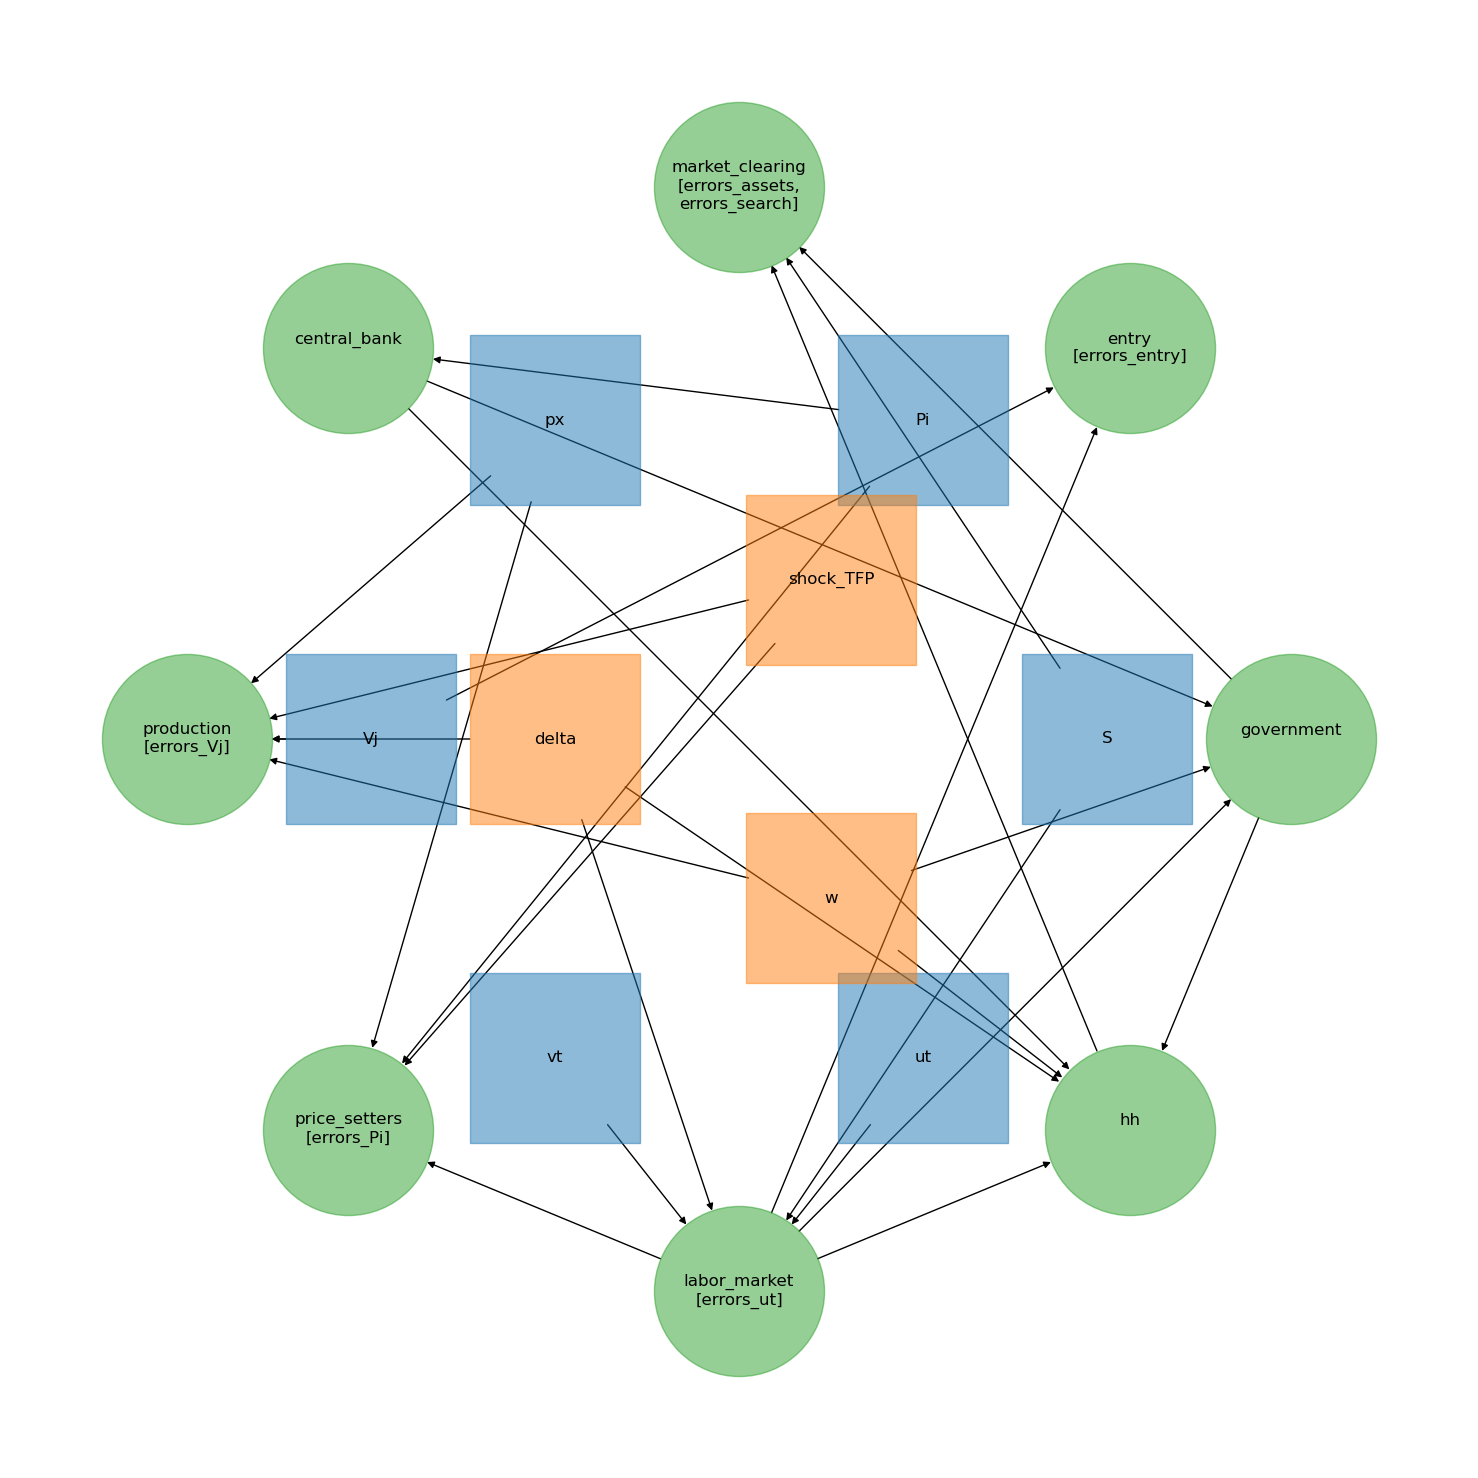

In [5]:
model.draw_DAG(figsize=(15,15),node_size=15000,order=['shocks','unknowns','blocks'])

In [6]:
model.find_ss(do_print=True)

par.A = 0.3680
par.kappa = 2.3548
ss.w = 0.7000
ss.delta = 0.0250
ss.lambda_u = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0551
ss.ut = 0.0787
ss.S = 0.0787
guess:
     R =   0.97840763 -> B-A_hh =   0.70000000
find bracket to search in:
  0: R =   0.97965763 -> B-A_hh =   0.70000000
  1: R =   0.99153263 -> B-A_hh =   0.65474371
  2: R =   0.99747013 -> B-A_hh =   0.50145722
  3: R =   1.00043888 -> B-A_hh =   0.26689446
  4: R =   1.00192325 -> B-A_hh =  -0.03589529
brentq:
  0: R =   1.00174728 -> B-A_hh =   0.01790353
  1: R =   1.00180584 -> B-A_hh =   0.00093355
  2: R =   1.00180898 -> B-A_hh =  -0.00000419
  3: R =   1.00180897 -> B-A_hh =   0.00000001
  4: R =   1.00180897 -> B-A_hh =   0.00000000
  5: R =   1.00180897 -> B-A_hh =  -0.00000000

R =   1.00180897

ss.qB = 0.7000
ss.RealR = 1.0018
steady state found in 30.6 secs


### 1.1. <a id='toc1_1_'></a>[Tests](#toc0_)

In [7]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and targets are zero

shocks: shock_TFP delta w 
unknowns: px Vj vt ut S Pi 
blocks.production
 errors_Vj        0.0e+00 [target]
blocks.labor_market
 theta            0.0e+00
 lambda_v         0.0e+00
 lambda_u         0.0e+00
 v                0.0e+00
 u                0.0e+00
 entry            0.0e+00
 errors_ut        0.0e+00 [target]
blocks.entry
 errors_entry     0.0e+00 [target]
blocks.price_setters
 errors_Pi        0.0e+00 [target]
blocks.central_bank
 R                0.0e+00
 RealR            0.0e+00
 q                0.0e+00
 RealR_ex_post    0.0e+00
blocks.government
 tau              0.0e+00
 B                0.0e+00
 qB               0.0e+00
 UI               0.0e+00
 Yt_hh            0.0e+00
hh
 A_hh             0.0e+00
 C_hh             0.0e+00
 S_hh             0.0e+00
blocks.market_clearing
 errors_assets    3.0e-10 [target]
 errors_search    2.2e-15 [target]


## 2. <a id='toc2_'></a>[Transition path](#toc0_)

In [8]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for RealR_ex_post   in 1.0 secs
curly_Y and curly_D calculated for delta           in 1.0 secs
curly_Y and curly_D calculated for lambda_u        in 1.0 secs
curly_Y and curly_D calculated for tau             in 0.9 secs
curly_Y and curly_D calculated for w               in 0.9 secs
curly_E calculated in 1.6 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 6.5 secs

full Jacobians:
full Jacobian to unknowns computed in 0.8 secs [in evaluate_blocks(): 0.4 secs]
full Jacobian to shocks computed in 0.5 secs [in evaluate_blocks(): 0.2 secs]


In [9]:
model.find_transition_path(shocks=['shock_TFP'])

In [10]:
model.find_IRFs(shocks=['shock_TFP'])

### shocks ###


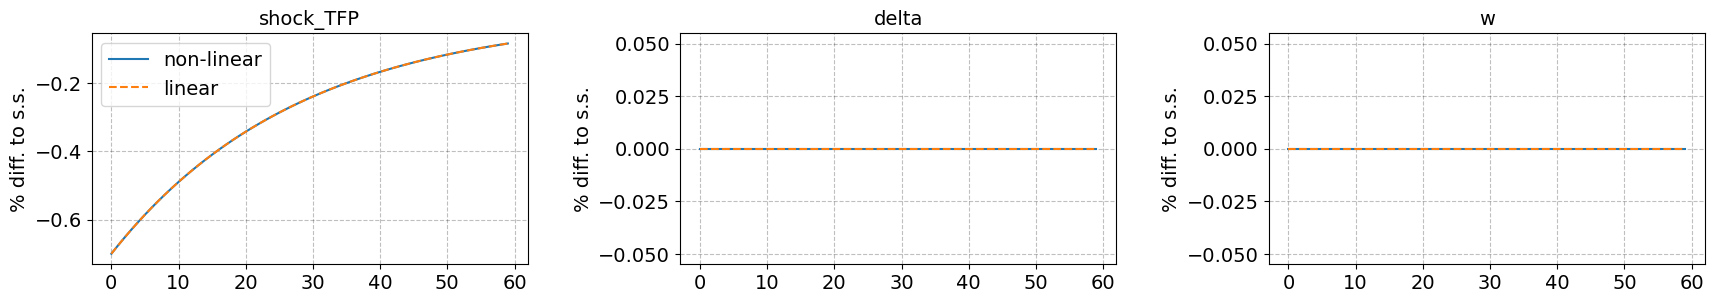


### varnames ###


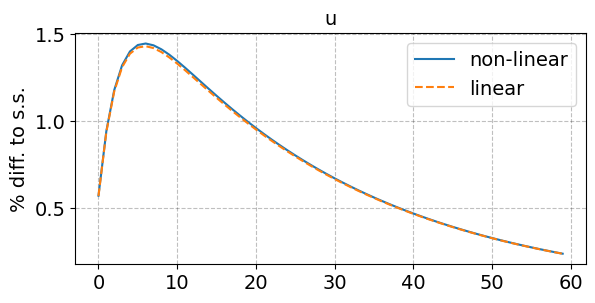


### tagets ###


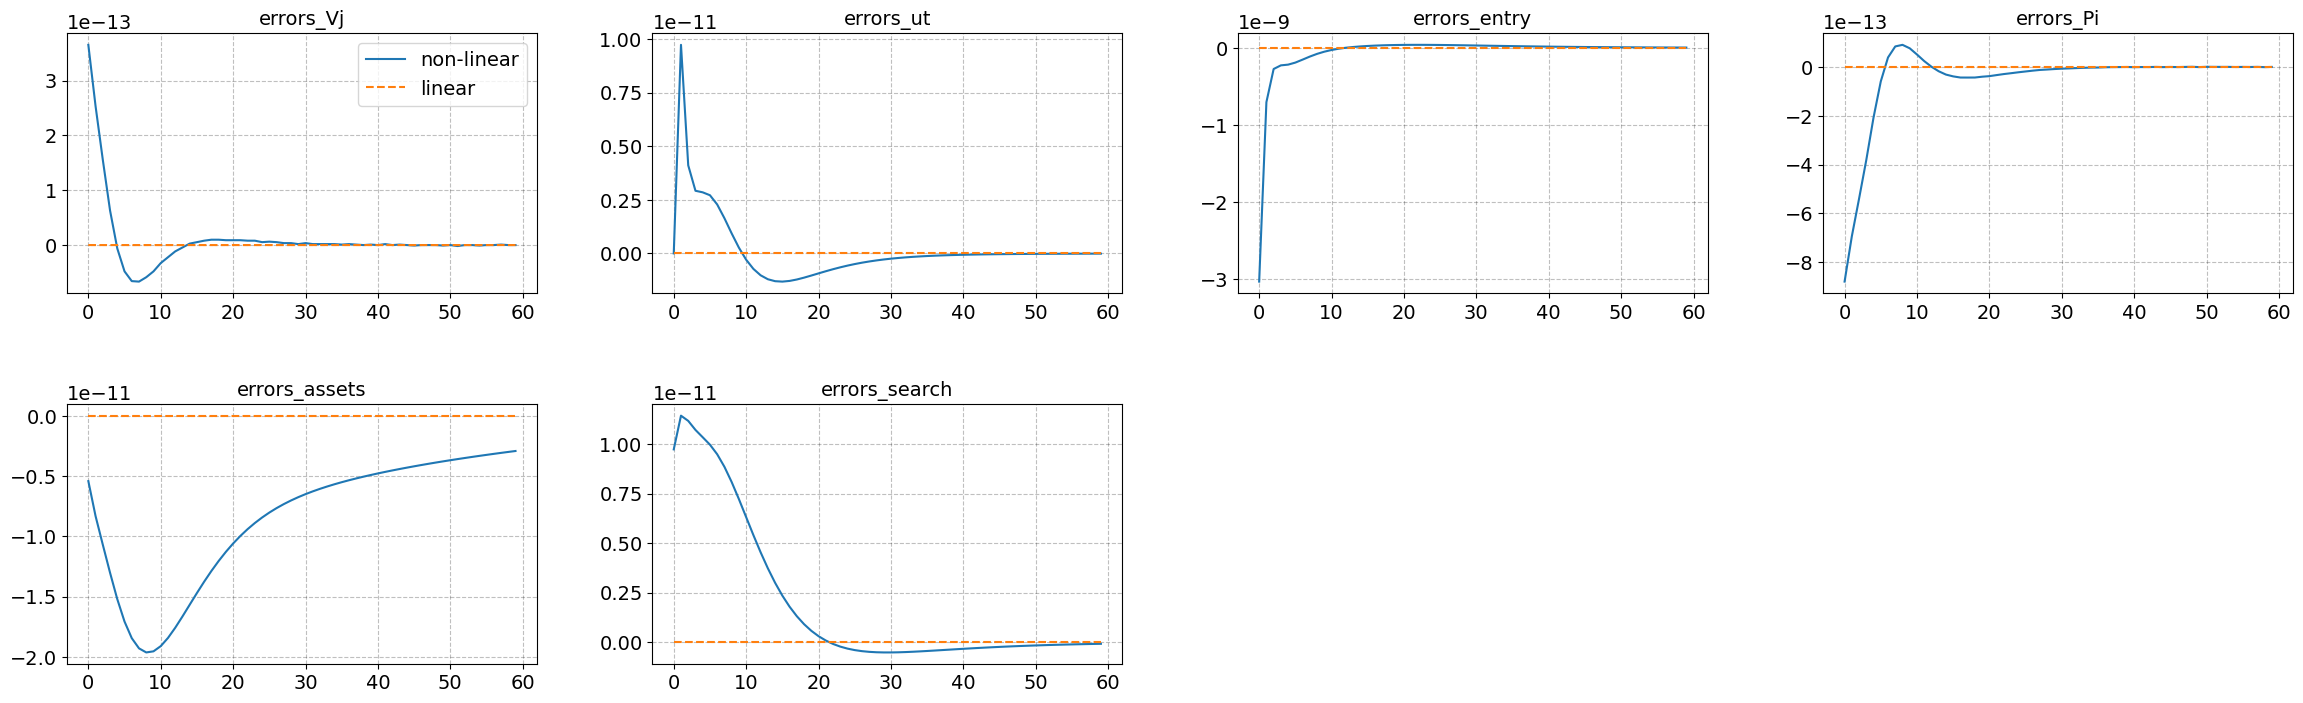

In [11]:
model.show_IRFs(['u'],T_max=60,do_linear=True)

## 3. <a id='toc3_'></a>[Simulation](#toc0_)

In [12]:
sim = model.sim

In [13]:
np.random.seed(1917)
try:
    model.simulate(do_print=True)
except Exception as e:
    print(e) 

simulation prepared in 3.5 secs [solution matrix: 0.3 secs, households: 3.2 secs]
aggregates simulated in 0.5 secs
household policies simulated in 3.0 secs
timing varying z_trans not implemented


In [14]:
def model_sim():
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    ax = fig.add_subplot(1,2,1)
    ax.set_title('TFP')
    ax.plot(ss.shock_TFP+sim.dshock_TFP,ls='--',)
    ax.axhline(ss.shock_TFP,color='black',zorder=0)
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title('unemployment')
    ax.plot(ss.u+sim.du,ls='--',)
    ax.axhline(ss.u,color='black',zorder=0)
    

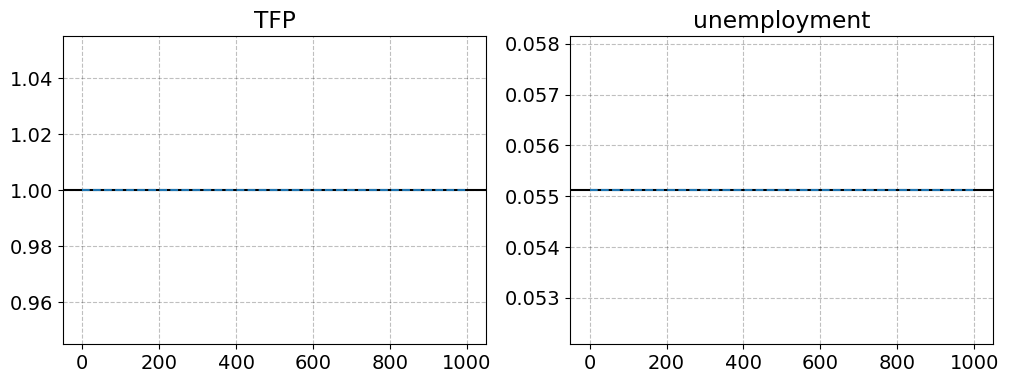

In [15]:
model_sim()